### Script to
1. get dosage range overlap across datasets, dosage range in GDSC andother metdata for each drug for analysis

NOTE!!!!!!: rerun script after generating "GDSC_pair_dosage_range.csv" from Task0a script

In [1]:
__author__ = 'Aanchal'

In [2]:
import pandas as pd
import FUNCTIONS as f
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [3]:
impClsOnly=1

In [4]:
plotting_df=pd.DataFrame();

#### fetch dosage overlap

In [5]:
dr_metadata= f.get_common_drugs_metadata("../data/metadata_2019_08_15_aanchal.xlsx", "common_drugs")

plotting_df['Standard drug name']=dr_metadata['Standard drug name']
plotting_df['dosage range overlap']=dr_metadata['dosage range overlap']
plotting_df['GDSC dosage length']=dr_metadata['GDSC dosage length']
plotting_df['GDSC min dosage']=dr_metadata['GDSC min dosage']
plotting_df['GDSC max dosage']=dr_metadata['GDSC max dosage']

## INITIALIZATION 

In [6]:
FeatureMatrix=pd.read_csv('../data_processed/FittedCurvesCommonPairs_features/Feature_Matrix_FLatPerDrugFitting_15features.csv') # #Normalized_outliersCapped

FeatureMatrix=FeatureMatrix[['Standard cell line name','Standard drug name','IS','mae_fitness','ic50_mode','m_mode','log2(max_dosage_bothDatasets)']]

In [7]:
pair_dosages=pd.read_csv('../data_processed/GDSC1_pair_dosage_range.csv').sort_values('cell line name')
pair_dosages=pair_dosages.rename(columns={'cell line name':'Standard cell line name','drug name':'Standard drug name'})
FeatureMatrix=pd.merge(FeatureMatrix, pair_dosages,on=['Standard cell line name','Standard drug name']) 

mu, sigma, Amp for 2 modes=> [ -4.02974493   1.10291438  76.75906788   4.5280398    5.10408333
 174.8162648 ]
Th=mu+std of 1st gaussian pofile: -1.9948772513860416


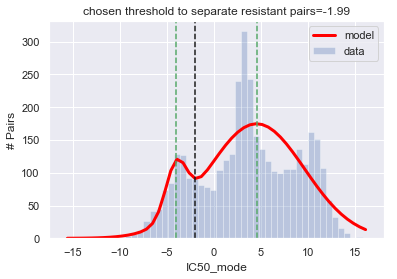

In [8]:
from pylab import hist
'''hist(FeatureMatrix['ic50_mode'] , bins=100) #FeatureMatrix['IS'] #FeatureMatrix['m_mode']
plt.title('Distribution of ic50_mode for all pairs')
plt.xlabel('value of ic50_mode')
plt.ylabel('# pairs')
plt.show()'''
#temp=df[df['sensitivity_calls_ic50_label']==1]
#hist(temp['ic50_mode'] , bins=100)

[mus,stds, params,xh,yh] = f.fit_mixtureOfGaussians(FeatureMatrix[['ic50_mode']],[2.5,5,130,  10,5,60])

#st_ind=np.where(params==max(mus))
th=mus[0]+2*stds[0] #not using anymore since both the dsitributions mus tbe used to separate the 2 modes..not just 1

th= f.split_bimodal(xh, f.bimodal(xh,params[0],params[1],params[2],params[3],params[4],params[5])  ,mus)[0]

plt.axvline(x=mus[0], color='g', linestyle='--', label='mu1')
plt.axvline(x=mus[1], color='g', linestyle='--', label='mu2')
plt.axvline(x=th ,color='k', linestyle='--', label='threshold')
#plt.axvline(x=7.06 ,color='r', linestyle='--', label='threshold')

plt.xlabel('IC50_mode')
plt.ylabel('# Pairs')
plt.title('chosen threshold to separate resistant pairs='+str( th.round(2)) )
print("Th=mu+std of 1st gaussian pofile:", th)
plt.savefig('../figures/InconsistencyFactorAnalysis/IC50_mode_distibution.svg')

In [9]:
#code to check what each peak corresponds to

t1=FeatureMatrix[FeatureMatrix['ic50_mode']<0][['Standard cell line name','Standard drug name']]
t2=FeatureMatrix[(FeatureMatrix['ic50_mode']>=0) & (FeatureMatrix['ic50_mode']<7.06)][['Standard cell line name','Standard drug name']]
t3=FeatureMatrix[FeatureMatrix['ic50_mode']>=7.06][['Standard cell line name','Standard drug name']]

src="D:/AanchalMongia_phdClg/Phd/INTERNSHIP/Aanchal_GIS_PC/figures/FittedCurves_commonPairs_plots/"
dst="D:/AanchalMongia_phdClg/Phd/INTERNSHIP/Debugging_folder/commonPairs_3peaksOfIC50/"
f.copyPastePlots(src,dst+"peak1/",[],[],[],[],t1,0)
f.copyPastePlots(src,dst+"peak2/",[],[],[],[],t2,0)
f.copyPastePlots(src,dst+"peak3/",[],[],[],[],t3,0)

curves saved
curves saved
curves saved


In [25]:
FeatureMatrix['Sensitivity_basedOnIC50th'] = np.where(FeatureMatrix['ic50_mode']> th, 1, 0)

In [26]:
th

7.063382706349541

In [27]:

#filter Cls which havent been tested for all drugs
if(impClsOnly==1):
    all_cls=FeatureMatrix.groupby(FeatureMatrix['Standard cell line name']).count()[['Standard drug name']]
    FeatureMatrix_impcls=FeatureMatrix.loc[FeatureMatrix['Standard cell line name'].isin(all_cls[all_cls['Standard drug name']==15].index)]
else:
    FeatureMatrix_impcls=FeatureMatrix

#filter resistant Cls
FeatureMatrix_sensitivePairs=FeatureMatrix_impcls[FeatureMatrix_impcls['ic50_mode']<=th]

#get mean IS
drug_wise_mean=FeatureMatrix_sensitivePairs.groupby('Standard drug name')['Standard drug name','IS'].mean() #takes med of all cols
drug_wise_mean.rename(columns={'IS': 'mean IS'}, inplace=True)


#get median IS
drug_wise_median=FeatureMatrix_sensitivePairs.groupby('Standard drug name')['Standard drug name','IS','ic50_mode'].median() #takes med of all cols
drug_wise_median.rename(columns={'IS': 'median IS', 'ic50_mode': 'median ic50_mode'}, inplace=True)

AAA_matrix=FeatureMatrix_sensitivePairs
AAA_matrix=AAA_matrix.set_index('Standard drug name')

In [28]:
len(FeatureMatrix_sensitivePairs)

675

In [29]:
#df=FeatureMatrix_sensitivePairs.groupby(FeatureMatrix_sensitivePairs['Standard drug name']).agg({'Sensitivity_basedOnIC50nMaxDosage': [sum, "count"]})#['Standard drug name','Sensitivity'].describe()#.count()#.size()#.unstack()
#df['fraction_resistant_CLs']=df['Sensitivity_basedOnIC50nMaxDosage']['sum']/df['Sensitivity_basedOnIC50nMaxDosage']['count']#['Sensitivity'][['sum']]#df['%age resistant CLs']=df['Standard drug name']
#Sensitivity_basedOnIC50th shud be used to find fraction of resistant cls

plotting_df['mean IS']=drug_wise_mean['mean IS']
plotting_df['median IS']=drug_wise_median['median IS']
plotting_df['median ic50_mode']=drug_wise_median['median ic50_mode']
plotting_df['#total CLs']=FeatureMatrix.groupby('Standard drug name').count()['Standard cell line name']
plotting_df['#CLs tested for all']=FeatureMatrix_impcls.groupby('Standard drug name').count()['Standard cell line name']
plotting_df['#sensitive CLs']=FeatureMatrix_sensitivePairs.groupby('Standard drug name').count()['Standard cell line name']

plotting_df['Target Pathway']=dr_metadata['Target Pathway']

In [30]:
###plotting_df=AAA_matrix.merge(plotting_df,left_index=True, right_index=True)

In [31]:
if(impClsOnly==1):
    plotting_df.to_csv('../data_processed/InconsistencyFactorAnalysis/drug_analysis_onlySensitiveCLs_testedFor15drugs.csv')
else:
    plotting_df.to_csv('../data_processed/InconsistencyFactorAnalysis/drug_analysis_onlySensitiveCLs.csv') 

In [32]:
plotting_df

,Standard drug name,dosage range overlap,GDSC dosage length,GDSC min dosage,GDSC max dosage,mean IS,median IS,median ic50_mode,#total CLs,#CLs tested for all,#sensitive CLs,Target Pathway
name,,,,,,,,,,,,
Crizotinib,Crizotinib,8.000000,8.0,-7.000000,1.000000,0.113579,0.104483,2.798528,111,66,57,RTK signaling
Erlotinib,Erlotinib,8.000000,8.0,-7.000000,1.000000,0.104502,0.093517,3.684525,97,66,34,EGFR signaling
Lapatinib,Lapatinib,8.000000,8.0,-7.000000,1.000000,0.111668,0.102102,3.160882,104,66,44,EGFR signaling
NVP-TAE684,NVP-TAE684,8.000000,8.0,-7.000000,1.000000,0.158247,0.145354,1.236829,111,66,58,RTK signaling
Nilotinib,Nilotinib,8.000000,8.0,-7.000000,1.000000,0.119039,0.111031,2.913680,253,66,47,ABL signaling
Nutlin-3a,Nutlin-3a,8.000000,8.0,-5.000000,3.000000,0.103574,0.096268,3.630165,330,66,27,p53 pathway
PD0325901,PD0325901,6.643856,8.0,-10.000000,-2.000000,0.169005,0.156612,1.715962,326,66,43,ERK MAPK signaling
PHA-665752,PHA-665752,8.000000,8.0,-7.000000,1.000000,0.099693,0.088355,3.426608,111,66,47,RTK signaling
PLX-4720,PLX-4720,7.678072,8.0,-4.678072,3.321928,0.094246,0.085146,5.391576,322,66,17,ERK MAPK signaling
